**Introduction:** In this notebook we compare the speed of edge probing of the following three implementations
*   jiant 1.3.2
*   jiant 2.2.0
*   our own implementation (https://github.com/SwiftPredator/How-Does-Bert-Answer-QA-DLP2021/blob/main/src/probing-tasks/replicate/probing_tasks.ipynb)


Before running make sure to set the runtime type to GPU (both jiant versions don't support TPUs).

**jiant 1.3.2:** First we install the dependencies for jiant 1.3.2 and clone the repository.

In [ ]:
!pip install allennlp==0.8.4
!pip install overrides==3.1.0
!pip install jsondiff
!pip install sacremoses
!pip install pyhocon==0.3.35
!pip install transformers==2.6.0
!pip install python-Levenshtein==0.12.0
!pip install tensorflow==1.15.0

!python -m nltk.downloader perluniprops nonbreaking_prefixes punkt

!pip uninstall overrides
!pip install overrides==3.1.0

!pip install tensorflow==1.15

Restart the runtime now. Clone the jiant and OntoNotes repository and set some environment variables.

In [ ]:
!git clone --branch v1.3.2  --recursive https://github.com/nyu-mll/jiant.git jiant
!git clone https://github.com/yuchenlin/OntoNotes-5.0-NER-BIO.git

import os
os.environ['JIANT_PROJECT_PREFIX'] = "/content/output"
os.environ['JIANT_DATA_DIR'] = "/content/data"
os.environ['WORD_EMBS_FILE'] = "/content/embs"

Copy the ontonotes path (/content/OntoNotes-5.0-NER-BIO/conll-formatted-ontonotes-5.0) to /content/jiant/probing/get_and_process_all_data.sh
Comment out SPR data and tokenizing for OpenAI, Moses and bert-large in /content/jiant/probing/get_and_process_all_data.sh. Set JIANT_DATA_DIR to "/content/data". Run the next cell to preprocess the data

In [ ]:
%cd /content/
!./jiant/probing/get_and_process_all_data.sh

Afterwards save the data to Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!cp -r "/content/data" "/content/drive/MyDrive/data"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


If you have already preprocessed and saved the data, you can just load it from Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!cp -r "/content/drive/MyDrive/data" "/content/data"

Before running the next cell go to /content/jiant/jiant/config/defaults.conf and set max_vals in edges-tmpl-large and edges-tmpl-small to 5 and val_interval in edges-tmpl and edges-tmpl-small to 1000. Restart the runtime afterwards.

To circumvent any difficulties with adding tasks, we just time tasks that are already implemented in jiant. For some reason the runtime has to be factory reset after each task.

In [ ]:
tasks = [
    #"edges-ner-ontonotes", 
    #"edges-rel-semeval",
    "edges-coref-ontonotes",
    ]

models = [
    "bert-base-uncased", 
    ]

In [ ]:
%cd /content/jiant/

import jiant.__main__ as main
from timeit import default_timer as timer
import os
import json

os.environ["JIANT_PROJECT_PREFIX"] = "/content/output/"
os.environ["JIANT_DATA_DIR"] = "/content/data/"
os.environ["WORD_EMBS_FILE"] = "/content/embs/"

with open("/content/results.json", "r") as f:
    results = json.load(f)
if results is None:
    results = {}

implementation_results = results.setdefault("jiant 1.3.2", {})

for model in models:
    implementation_results[model] = {}
    for task in tasks:
        start = timer()
        main.main([
                   "--config_file",
                   "/content/jiant/jiant/config/edgeprobe/edgeprobe_bert.conf",
                   "-o",
                   f"target_tasks={task},exp_name=timeit,input_module={model},max_seq_len=384"
                   ])
        end = timer()
        implementation_results[model][task] = end - start

print(results)
with open("/content/results.json", "w") as f:
    json.dump(results, f)

**jiant 2.2.0:** We follow the same steps as in the reproduced notebook.

In [ ]:
!git clone https://github.com/SwiftPredator/How-Does-Bert-Answer-QA-DLP2021.git

# copy the modified jiant lib to the /content/
!mv "/content/How-Does-Bert-Answer-QA-DLP2021/src/probing-tasks/jiant" "/content/"

%cd jiant
!pip install -r requirements-no-torch.txt
!pip install --no-deps -e ./
!pip install gdown  # lib to download file from googlde drive link

Restart the runtime now. When restarting the runtime run from here on.

In [ ]:
%cd /content/jiant

import jiant.utils.python.io as py_io
import jiant.utils.display as display
import os

def init_task_config(task_name, size):
    jiant_task = task_name
    if(task_name == "sup-squad" or task_name == "sup-babi"):
        jiant_task = "coref"  # use coref task to probe supporting facts task because of the analog structure of jiant EP json format

    os.makedirs("/content/tasks/configs/", exist_ok=True)
    os.makedirs(f"/content/tasks/data/{task_name}", exist_ok=True)

    py_io.write_json({
        "task": jiant_task,
        "paths": {
        "train": f"/content/tasks/data/{task_name}/{size}/train.jsonl",
        "val":   f"/content/tasks/data/{task_name}/{size}/val.jsonl",
        },
        "name": jiant_task
        }, f"/content/tasks/configs/{task_name}_config.json")

task_names = [
              "ner", 
              "semeval", 
              "coref",    
              #"ques" 
              #"sup-squad", 
              #"sup-babi",
              #"sup-hotpot",
             ]

size = "timing"

for task_name in task_names:
    init_task_config(task_name, size)

In [2]:
# copy the task data to the tasks folder created above
!cp -r "/content/How-Does-Bert-Answer-QA-DLP2021/src/probing-tasks/data" "/content/tasks/"

In [ ]:
import jiant.proj.main.export_model as export_model

models = [
          "bert-base-uncased", 
          ]

for model in models:
    export_model.export_model(
        hf_pretrained_model_name_or_path=model,
        output_base_path=f"/content/models/{model}",
        )

In [ ]:
import jiant.shared.caching as caching
import jiant.proj.main.tokenize_and_cache as tokenize_and_cache

seq_length_options = {
    "ner":        384, 
    "semeval":    384, 
    "coref":      384,
    "ques":       128,     
    "sup-squad":  384, 
    "sup-babi":   384,
    "sup-hotpot": 384,
    }

# Tokenize and cache each task
def tokenize(task_name, model):
    tokenize_and_cache.main(tokenize_and_cache.RunConfiguration(
        task_config_path=f"/content/tasks/configs/{task_name}_config.json",
        hf_pretrained_model_name_or_path=model,
        output_dir=f"/content/cache/{task_name}",
        phases=["train", "val"],
        max_seq_length=seq_length_options[task_name],
        ))

for task_name in task_names:
    for model in models:
        tokenize(task_name, model)


In [5]:
import jiant.proj.main.scripts.configurator as configurator

def create_jiant_task_config(task_name):
    jiant_run_config = configurator.SimpleAPIMultiTaskConfigurator(
        task_config_base_path="/content/tasks/configs",
        task_cache_base_path="/content/cache",
        train_task_name_list=[task_name],
        val_task_name_list=[task_name],
        train_batch_size=32,
        eval_batch_size=32,
        epochs=50,
        num_gpus=1,
        ).create_config()
    os.makedirs("/content/tasks/run_configs/", exist_ok=True)
    py_io.write_json(jiant_run_config, f"/content/tasks/run_configs/{task_name}_run_config.json")
    #display.show_json(jiant_run_config)

In [6]:
import jiant.proj.main.runscript as main_runscript

def run_probing_task(task_name, model_name="bert-base-uncased", num_layers=1, bin_model_path=""):
    hf_model_name = model_name
    if(model_name == "bert-babi"):
        hf_model_name = "bert-base-uncased"
    
    run_args = main_runscript.RunConfiguration(
        jiant_task_container_config_path=f"/content/tasks/run_configs/{task_name}_run_config.json",
        output_dir=f"/content/tasks/runs/{task_name}",
        hf_pretrained_model_name_or_path=hf_model_name,
        model_path=f"/content/models/{model_name}/model/model.p",
        model_config_path=f"/content/models/{model_name}/model/config.json",
        learning_rate=1e-2,
        eval_every_steps=100,
        do_train=True,
        do_val=True,
        do_save=True,
        force_overwrite=True,
        num_hidden_layers=num_layers,
        bin_model_path=bin_model_path,
        )
    return main_runscript.run_loop(run_args)

In [7]:
from timeit import default_timer as timer

def probe(model, task_name, n_layers, dataset_size):
    init_task_config(task_name, dataset_size)
    #tokenize(task_name, model)
    create_jiant_task_config(task_name)
    start = timer()
    run_probing_task(task_name, model, n_layers)
    end = timer()
    return end - start

To avoid lenghty tokenization and caching we run for 50 epochs instead of 5, use train datasets with size 320 (10 batches) and evaluate every 100 steps. The results have to be multiplied by 10 to be comparable to the other implementations.

In [ ]:
import json
import os

if os.path.isfile("/content/results.json"):
    with open("/content/results.json", "w") as f:
        results = json.load(f)
else:
    results = {}

implementation_results = results.setdefault("jiant 2.2.0", {})

for model in models:
    implementation_results[model] = {}
    for task in task_names:
        implementation_results[model][task] = probe(model, task, 1, "test") * 10

print(results)
with open("/content/results.json", "w") as f:
    json.dump(results, f)

**Our own implementation:** Change the runtime to TPU now and run the following cell to install our code. Restart the runtime afterwards.


In [ ]:
!git clone https://github.com/SwiftPredator/How-Does-Bert-Answer-QA-DLP2021/

!mv "/content/How-Does-Bert-Answer-QA-DLP2021/src/probing-tasks/data" "/content/"
!mv "/content/How-Does-Bert-Answer-QA-DLP2021/src/probing-tasks/replicate" "/content/"

%cd /content/replicate
!pip install -r requirements.txt
!pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl

In [ ]:
%cd /content/replicate
import torch
import torch.nn as nn
import torch.utils.data as data
from transformers import AutoModel, AutoTokenizer

from edge_probing_utils import (
    JiantDatasetSingleSpan,
    JiantDatasetTwoSpan
    )
import edge_probing as ep
import edge_probing_tpu as ep_tpu

In [ ]:
tasks = [
    "ner", 
    "semeval",
    "coref",
    ]

task_types = {
    "ner": "single_span", 
    "semeval": "single_span",
    "coref": "two_span",
    }

models = [
    "bert-base-uncased", 
    ]

task_labels_to_ids = {
    "ner": {'ORDINAL': 0, 'DATE': 1, 'PERSON': 2, 'LOC': 3, 'GPE': 4, 'QUANTITY': 5, 'ORG': 6, 'WORK_OF_ART': 7, 'CARDINAL': 8, 'TIME': 9, 'MONEY': 10, 'LANGUAGE': 11, 'NORP': 12, 'PERCENT': 13, 'EVENT': 14, 'LAW': 15, 'FAC': 16, 'PRODUCT': 17},
    "coref": {"0": 0, "1": 1},
    "semeval": {'Component-Whole(e2,e1)': 0, 'Other': 1, 'Instrument-Agency(e2,e1)': 2, 'Member-Collection(e1,e2)': 3, 'Entity-Destination(e1,e2)': 4, 'Content-Container(e1,e2)': 5, 'Message-Topic(e1,e2)': 6, 'Cause-Effect(e2,e1)': 7, 'Product-Producer(e2,e1)': 8, 'Member-Collection(e2,e1)': 9, 'Entity-Origin(e1,e2)': 10, 'Cause-Effect(e1,e2)': 11, 'Component-Whole(e1,e2)': 12, 'Message-Topic(e2,e1)': 13, 'Product-Producer(e1,e2)': 14, 'Entity-Origin(e2,e1)': 15, 'Content-Container(e2,e1)': 16, 'Instrument-Agency(e1,e2)': 17, 'Entity-Destination(e2,e1)': 18},
    }

In [ ]:
import torch_xla
import torch_xla.core.xla_model as xm
import os
import json
import matplotlib.pyplot as plt
from google.colab import drive
from timeit import default_timer as timer

loss_function = nn.BCELoss()
batch_size = 32
num_layers = [12]
num_workers = 0

device = xm.xla_device()

# Disable warnings.
os.environ["TOKENIZERS_PARALLELISM"] = "false"

def probe(model, task, size):
    tokenizer = AutoTokenizer.from_pretrained(model)
    train_data = ep.tokenize_jiant_dataset(
            tokenizer,
            *(ep.read_jiant_dataset(f"/content/data/{task}/{size}/train.jsonl")),
            task_labels_to_ids[task],
            )
    val_data = ep.tokenize_jiant_dataset(
            tokenizer,
            *(ep.read_jiant_dataset(f"/content/data/{task}/{size}/val.jsonl")),
            task_labels_to_ids[task],
            )
    test_data = ep.tokenize_jiant_dataset(
            tokenizer,
            *(ep.read_jiant_dataset(f"/content/data/{task}/{size}/test.jsonl")),
            task_labels_to_ids[task],
            )
    if task_types[task] == "single_span":
        train_data = JiantDatasetSingleSpan(train_data)
        val_data = JiantDatasetSingleSpan(val_data)
        test_data = JiantDatasetSingleSpan(test_data)
    elif task_types[task] == "two_span":
        train_data = JiantDatasetTwoSpan(train_data)
        val_data = JiantDatasetTwoSpan(val_data)
        test_data = JiantDatasetTwoSpan(test_data)
    train_loader = data.DataLoader(train_data, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers)
    val_loader = data.DataLoader(val_data, batch_size=batch_size, pin_memory=True, num_workers=num_workers)
    test_loader = data.DataLoader(test_data, batch_size=batch_size, pin_memory=True, num_workers=num_workers)
    start = timer()
    ep_tpu.probing(ep.ProbeConfig(
        train_loader,
        val_loader,
        test_loader,
        model,
        num_layers,
        loss_function,
        task_labels_to_ids[task],
        task_types[task],
        lr=0.0001,
        max_evals=5,
        eval_interval=1000,
        dev=device,
        ))
    end = timer()
    return end - start

with open("/content/results.json", "r") as f:
    results = json.load(f)
if results is None:
    results = {}

implementation_results = results.setdefault("jiant 1.3.2", {})

for model in models:
    implementation_results[model] = {}
    for task in tasks:
        implementation_results[model][task] = probe(model, task, "big")

print(results)
with open("/content/results.json", "w") as f:
    json.dump(results, f)

**Visualization:** Change the task names in /content/results.json to be the same for all implementations

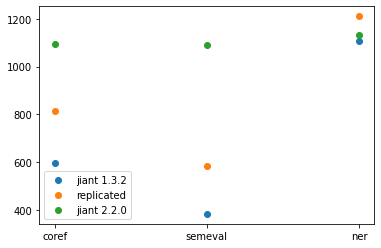

In [9]:
import matplotlib.pyplot as plt
import json

with open("/content/results.json", "r") as f:
    results = json.load(f)

for implementation in results.keys():
    plt.scatter(
        list(results[implementation]["bert-base-uncased"].keys()),
        list(results[implementation]["bert-base-uncased"].values()),
        )

plt.legend(list(results.keys())) 
plt.show()